In [0]:
!git clone https://github.com/souravyuvrajj/datasets.git

fatal: destination path 'datasets' already exists and is not an empty directory.


In [0]:
from sklearn.base import clone
from sklearn.base import BaseEstimator, ClassifierMixin
# from utils import balanced_class_weights
import numpy as np
import sklearn.metrics
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix
from patsy import dmatrices
from math import log
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_recall_fscore_support as score
import copy 
from sklearn.preprocessing import StandardScaler 
from pylab import rcParams
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [0]:
df = pd.read_excel('datasets/default of credit card clients.xls',header=1)

In [0]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [0]:
df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))
df = df.drop('default payment next month', axis=1)

print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

Target variable:       'default payment next month' -> 'target'
Explanatory variables:  23
Number of Observations: 30000


In [0]:
df.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Attributes description
This study uses 23 variables as explanatory variables, extracted/interpreted from : 
    
```
   ----------------------------------------------------------------------------------------
   Name                 Explantion        
   -------------------- -------------------------------------------------------------------
   limit_bal            Amount of the given credit (NT dollar): 
                        it includes both the individual consumer credit 
                        and his/her family (supplementary) credit.
   
   sex                  Gender 
                        (1 = male; 2 = female)
   
   education            Education
                        (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage             Marital status 
                        (1 = married; 2 = single; 3 = others)
   
   age                  Age (years)
   
   pay_1 - pay_6        History of past payment. Past monthly payment records 
                        From April to September, 2005 as follows:
                        
                        pay_1 = the repayment status in September, 2005
                        pay_2 = the repayment status in August, 2005
                        ...
                        pay_6 = the repayment status in April, 2005 
                        
                        The measurement scale for the repayment status is: 
                        -1 = pay duly; 
                        1 = payment delay for one month 
                        2 = payment delay for two months
                        ...
                        8 = payment delay for eight months 
                        9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5  Amount of bill statement (NT dollar). 
                        bill_amt1 = amount of bill statement in September, 2005 
                        bill_amt2 = amount of bill statement in August, 2005
                        ...
                        bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6    Amount of previous payment (NT dollar)
                        pay_amt1 = amount paid in September, 2005
                        pay_amt2 = amount paid in August, 2005
                        ...
                        pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------
```


In [0]:
df.isnull().sum()

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
target       0
dtype: int64

defaulting accounts are 22.12% out of 30000 observations


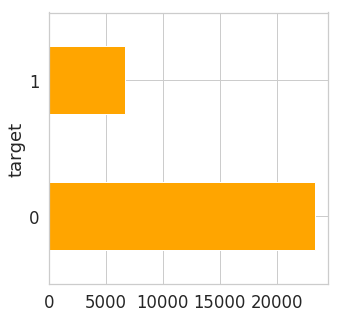

In [0]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

In [0]:
dfd = df.copy(deep=False)
dfd['sex'] = dfd['sex'].astype('category').cat.rename_categories(['M', 'F'])
dfd['marriage'] = dfd['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])
dfd['age_cat'] = pd.cut(dfd['age'], range(0, 100, 10), right=False)


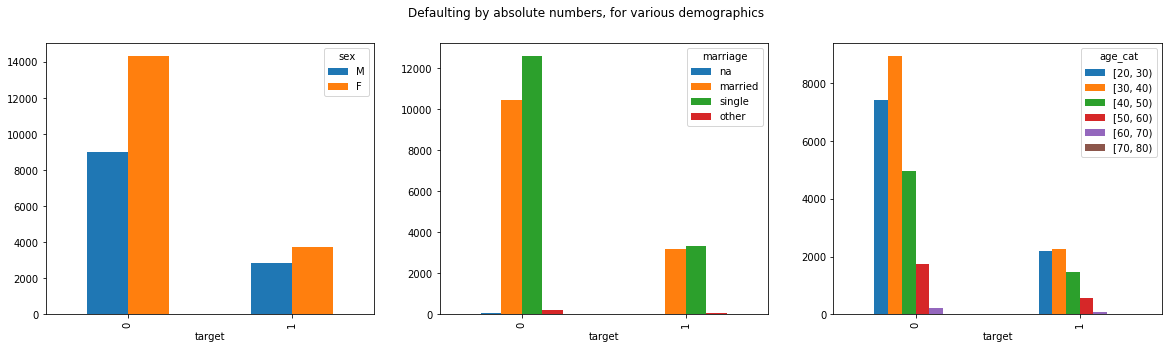

In [0]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = dfd.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = dfd.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = dfd.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

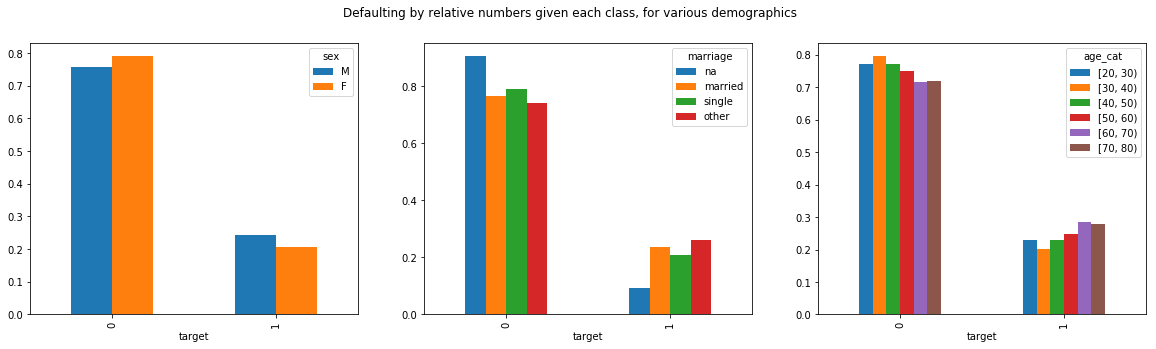

In [0]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = dfd.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = dfd.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = dfd.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

#### Visualization: Confusion matrices and AUC curves

In [0]:
def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])


In [0]:
x = df.iloc[:,0:23]
y = df.iloc[:, 23]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


### Model

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(60,50), max_iter=100,learning_rate_init=0.001)  
mlp.fit(X_train, y_train.values.ravel())  

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
predictions_on_train = mlp.predict(X_train) 
predictions_on_test = mlp.predict(X_test) 

In [0]:
print(confusion_matrix(y_test,predictions_on_test))  
print(classification_report(y_test,predictions_on_test)) 
cm = confusion_matrix(y_test,predictions_on_test)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
cost = 100*FN + 10*FP +1*TP
print('cost = ',cost)
hit_rate = TP/(TP+FP)
print("hit rate = ",hit_rate)
Detection_Rate = TP / (TP + FN)
print('Detection Rate = ',Detection_Rate)

[[6571  469]
 [1309  651]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7040
           1       0.58      0.33      0.42      1960

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.71      0.63      0.65      9000
weighted avg       0.78      0.80      0.78      9000

cost =  136241
hit rate =  0.58125
Detection Rate =  0.33214285714285713


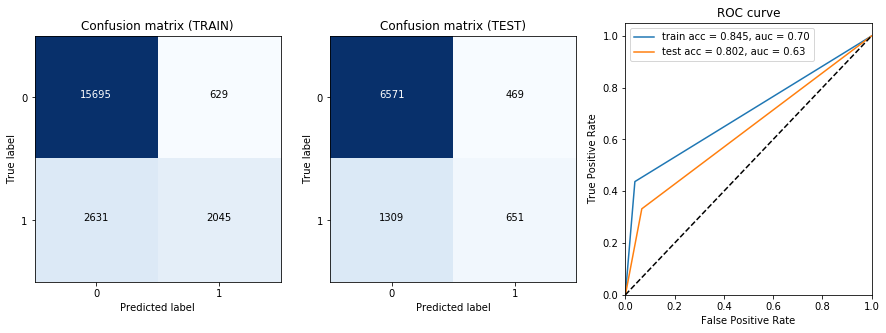

In [0]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)
plot_cm(ax[0],  y_train, predictions_on_train, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1],  y_test, predictions_on_test,   [0,1], 'Confusion matrix (TEST)')
plot_auc(ax[2], y_train, predictions_on_train, y_test, predictions_on_test)
    

### MetaCost

In [0]:
x = df.iloc[:,0:23]
y = df.iloc[:, 23]

(30000, 22)

In [0]:
def full_resamples(X, Y, m,n):
    
    s = [None] * m
    for i in range(m):
        r = np.random.randint(0, len(Y), n)
        s[i] = (X[r], Y[r])
    return s  

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [0]:
c=np.array([[0,1],[2,-3]]) #recall 73% precision 36%
# c=np.array([[0,2],[6,-3]]) #recall 67% precision 39%
MLP = MLPClassifier(hidden_layer_sizes=(60,50), max_iter=100,learning_rate_init=0.001,random_state=0) 
m=10
y=y_train
x=X_train
M = [None] * m
y = np.array(y, copy=True)
p=True
# Step 1. Train everything
for i, (Xt, yt) in enumerate(full_resamples(x, y, m,int(len(y_train)))):
    modelc=clone(MLP)
    M[i] = modelc.fit(Xt, yt)

# Step 2. Per observation, action (i.e. relabel)
for i in range(len(x)): 
    if p:
        Pj = [m.predict_proba(x[[i]]) for m in M]
    else:
        Pj = [(1, 0) if m.predict(x[[i]]) == 0 else (0, 1) for m in M]   
    P = np.mean(Pj, 0)
    j = np.argmin(np.matmul(P,c))
    y[i] = j

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

In [0]:
y=pd.DataFrame({"label":y})
y['label'].unique()

array([1, 0])

array([1, 0])

In [0]:
MLP.fit(X_train,y.values.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
predictions_on_train = MLP.predict(X_train) 
predictions_on_test = MLP.predict(X_test) 

In [0]:
print(confusion_matrix(y_test,predictions_on_test))  
print(classification_report(y_test,predictions_on_test)) 
cm = confusion_matrix(y_test,predictions_on_test)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
cost = 100*FN + 10*FP +1*TP
print('cost = ',cost)
hit_rate = TP/(TP+FP)
print("Precision = ",hit_rate)
Detection_Rate = TP / (TP + FN)
print('Recall = ',Detection_Rate)

[[4440 2600]
 [ 537 1423]]
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      7040
           1       0.35      0.73      0.48      1960

   micro avg       0.65      0.65      0.65      9000
   macro avg       0.62      0.68      0.61      9000
weighted avg       0.77      0.65      0.68      9000

cost =  81123
Precision =  0.35371613223962217
Recall =  0.7260204081632653
[[4425 2615]
 [ 523 1437]]
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      7040
           1       0.35      0.73      0.48      1960

   micro avg       0.65      0.65      0.65      9000
   macro avg       0.62      0.68      0.61      9000
weighted avg       0.78      0.65      0.68      9000

cost =  79887
Precision =  0.354639684106614
Recall =  0.7331632653061224


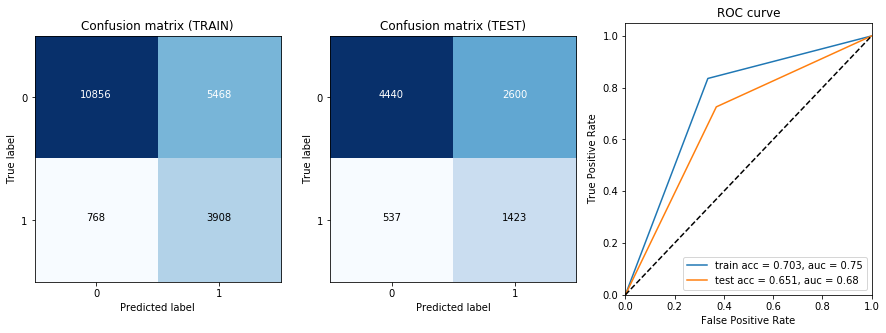

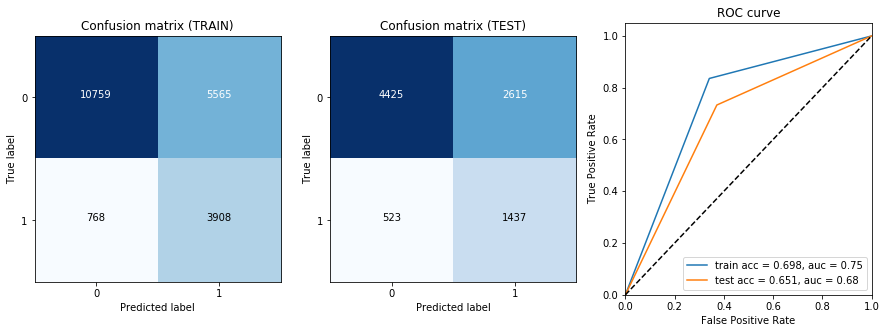

In [0]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)
plot_cm(ax[0],  y_train, predictions_on_train, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1],  y_test, predictions_on_test,   [0,1], 'Confusion matrix (TEST)')
plot_auc(ax[2], y_train, predictions_on_train, y_test, predictions_on_test)
    